# **Photovoltaic panel segmentation on building facades**

Ayca Duran*, Pedram Mirabian, Panagiotis Karapiperis, Christoph Waibel,
Bernd Bickel and Arno Schlueter

## Step 5: Model Evaluation - MaskrCNN

This notebook covers the evaluation of the MaskRCNN models using the Detectrion2 platform. The existing values in this notebook are related to the two best performing models featured in the paper.

### paths

In [ ]:
'''
GLOBAL SETUP
'''
from pathlib import Path
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount= False)
    repo_path = Path("/content/drive/MyDrive/PVFINDER")
except:
    repo_path = Path.cwd().parent
    raise EnvironmentError("Google Colab environment not detected. Please run this notebook in Google Colab to ensure all required workflows are functional.")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# set step-specific paths
datasets_folder = repo_path / "files" / "02_datasets"
models_folder = repo_path / "files" / "03_model_checkpoints" / "maskrcnn"
masks_folder = repo_path / "files" / "04_test_masks" / "maskrcnn"
metrics_folder = repo_path / "files" / "05_metrics" / "maskrcnn"

# input files
dataset_dir = datasets_folder / "dataset"
trained_models_folder = models_folder

# output files
mask_save_dir = masks_folder
metrics_save_dir = metrics_folder
eval_folder = metrics_folder / "ResultsPerImage"
metrics_folder = metrics_folder

# Setup

In [ ]:
#@title installation & imports

import sys
import os
import json
import pickle
import distutils.core



# Check if GPU is available
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!nvidia-smi

# Detectron2 (needs download on Google Colab)
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

#
import detectron2
from detectron2 import model_zoo
#
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.engine.hooks import HookBase
#
from detectron2.checkpoint import DetectionCheckpointer
#
from detectron2.evaluation import inference_context
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
#
from detectron2.config import get_cfg
#
import detectron2.utils
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.logger import log_every_n_seconds
setup_logger()
import detectron2.utils.comm as comm
#
from detectron2 import structures

# Logging
import time
import datetime
import logging
from tqdm import tqdm

# Required libraries
import csv
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from PIL import Image
import cv2
from pycocotools import mask as mask_utils
import gc
import warnings

# PyTorch (pre-installed on Google Colab)
import torch
from torch.utils.data import Dataset, DataLoader
!nvcc --version
TORCH_VERSION = (torch.__version__)
print("torch: ", TORCH_VERSION)
print("detectron2:", detectron2.__version__)

# Dataset Loading

In [ ]:
#@title load dataset

'''
Change the select value below to select the dataset. The options are as follows:
[i] Stratification      Augmentation            Includes    (#train, valid, test)
------------------------------------------------------------------------------------
[5] Stratified,         Augmented data,         PV+NonPV    (5768,  101,    105) m7
'''

#@title paths
for split in ["train", "valid", "test"]:
    try:
        MetadataCatalog.remove(split)
    except:
        pass
    try:
        DatasetCatalog.remove(split)
    except:
        pass

    register_coco_instances(split, {}, os.path.join(dataset_dir, split, "_annotations_case2.coco.json"), os.path.join(dataset_dir, split))
    print(f">>> split {split} with {len([item for item in os.listdir(os.path.join(dataset_dir, split)) if item.endswith('.jpg')])} images")

pv_only = False

# visualize samples from each split
for d in ["train", "valid", "test"]:
    dataset_dicts = DatasetCatalog.get(d)
    if pv_only == True:
        dataset_dicts = [item for item in dataset_dicts if len(item.get("annotations", [])) > 0]
        print(f'{len(dataset_dicts)} after filtering null annots...')

    metadata = MetadataCatalog.get(d)

    count = 5
    count = min(count, len(dataset_dicts))
    print(f">>> dataset {d} - showing {count} out of {len(dataset_dicts)}...")

    dim = 3
    cols = 5

    rows = math.ceil(count/cols)
    fig, axs = plt.subplots(rows, cols, figsize= (dim * cols, dim * rows), constrained_layout=True)
    fig.suptitle(f"{d.upper()} SET")

    axs = axs.flat
    for ax in axs:
        ax.tick_params(left = False, right = False ,
                        labelleft = False , labelbottom = False,
                        bottom = False, top = False)
    idx = -1

    for d in dataset_dicts[:count]:
        idx += 1
        img = Image.open(d["file_name"])
        visualizer = Visualizer(img, metadata= metadata, scale=1)
        out = visualizer.draw_dataset_dict(d)
        axs[idx].imshow(out.get_image())

# Model Training

In [ ]:
#@title def functions - just run this

def make_next(models_dir, d2model, d2epochs, d2lr, d2bs, d2wd, make= True) -> str:
    # Calculate model iteration
    models_dir_models = [item for item in os.listdir(models_dir) if item[0] != "."]
    if len(models_dir_models) != 0:
        nums = [text.split("_")[0] for text in models_dir_models]

        models = sorted(models_dir_models, key=lambda folder: int(folder.split('_')[0]))
        model_num = int(models[-1].split("_")[0]) + 1
    else:
        model_num = 0

    rem = 3 - len(str(model_num))
    zeroes = "0" * rem
    model_arch = d2model.split("/")[1]
    model_name = f"{zeroes}{model_num}_{model_arch}_{d2epochs}epochs_{d2lr}lr_{d2bs}bs_{d2wd}wd"

    model_dir = os.path.join(models_dir, model_name)
    if make:
        os.makedirs(model_dir, exist_ok=True)
        print(f">>> created model folder at\n{model_dir}")
    else:
        print(f">>> if make == true then folder will be created at\n{model_dir}")

    return model_dir

def model_name_from_num(model_num):
    zeroes = "0" * (3 - len(str(model_num)))
    model_name = None

    for folder in os.listdir(trained_models_folder):
        if folder.split("_")[0] == f"{zeroes}{model_num}":
            model_name = folder
    if model_name == None:
        raise Exception(f"Model with number {model_num} not found in\n{trained_models_folder}")

    return model_name

# Batch Metrics on Test Dataset

In [ ]:
#@title batch calculate metrics on test dataset
dataset = 'test'
dataset_dicts = DatasetCatalog.get(dataset)
metadata = MetadataCatalog.get(dataset)

print(f"Total image count {len(dataset_dicts)}")


# MAKE DATASET FOR EACH PAIR BEFORE RUNNING

model_nums = [7, 45]

if len(model_nums) == 0:
    trained_folders = os.listdir(trained_models_folder)
    model_nums = [int(item.split("_")[0]) for item in trained_folders if os.path.isdir(os.path.join(trained_models_folder, item))]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]

mask_combinations = [(7, 0.95), (45, 0.85)]

print(f">>> model nums: {model_nums}")
print(f">>> thresholds: {thresholds}")

plot = False
write = True
gt_written = False

for mn_index, model_num in enumerate(model_nums):
    print(f"\n\n\n>>> PROCESSING model num {model_num}... {mn_index}/{len(model_nums)}-1")

    model_name = model_name_from_num(model_num)
    model_dir = os.path.join(trained_models_folder, model_name)
    model_arch = "mask_rcnn_X_101_32x8d_FPN_3x"

    mask_save_dir


    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(f"COCO-InstanceSegmentation/{model_arch}.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.OUTPUT_DIR = model_dir
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

    for t_index, threshold in enumerate(thresholds):
        print(f"\n\n>>> PROCESSING threshold {threshold}... {t_index}/{len(thresholds)}-1")


        if (model_num, threshold) in mask_combinations:
            save_mask = True
        mask_save_folder = os.path.join(mask_save_dir, f"Masks_m{model_num}_t{threshold}_d{dataset}")
        gt_save_folder = os.path.join(mask_save_dir, f"Ground_Truth")
        os.makedirs(mask_save_folder, exist_ok= True)
        os.makedirs(gt_save_folder, exist_ok= True)



        print(f"\n>>> threshold {threshold}")

        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
        predictor = DefaultPredictor(cfg)

        idx = 0
        count = len(dataset_dicts)
        count = min(count, len(dataset_dicts) - idx)
        print(f"processing {count} images starting from {idx}...")

        total_maskIOU_list = []

        # detection_results = ['detTP', 'detFP', 'detFN', 'detTN']
        # detection_IOUs = [[], [], [], []]
        # detection_dict = dict(zip(detection_results, detection_IOUs))
        detection_dict = {}

        results_df = pd.DataFrame()
        detTP, detFP, detFN, detTN = 0, 0, 0, 0

        progbar = tqdm(total= len(dataset_dicts[idx:idx + count]))
        for d in dataset_dicts[idx:idx + count]:
            #print(f"\n# {idx}")
            #print(f"\n>>> {d}")

            idx += 1
            img = cv2.imread(d["file_name"])
            outputs = predictor(img)

            v1 = Visualizer(img[:, :, ::-1] * 0.1,
                        metadata= metadata,
                        scale= 1,
                        instance_mode=ColorMode.IMAGE_BW
            )

            v2 = Visualizer(img[:, :, ::-1] * 0.1,
                        metadata= metadata,
                        scale= 1,
                        instance_mode=ColorMode.IMAGE_BW
            )

            instances = outputs["instances"].to("cpu")

            out = v1.draw_dataset_dict(d)
            pred_img = v2.draw_instance_predictions(instances)

            bboxes_gt = torch.FloatTensor([[chunk['bbox'][0],
                                            chunk['bbox'][1],
                                            chunk['bbox'][0] + chunk['bbox'][2],
                                            chunk['bbox'][1] + chunk['bbox'][3]] for chunk in d['annotations']])

            bboxes_gt = structures.Boxes(bboxes_gt)
            bboxes_pred = instances.pred_boxes

            gt_count = len(bboxes_gt)
            pred_count = len(bboxes_pred)

            # print(f">>> bounding boxes:")
            # print(f"gt\t{gt_count}")
            # print(f"pred\t{pred_count}\n")

            # UNIFY GT MASKS INTO ONE (SHIFT TO SEMANTIC SEGMENTATION)
            gt_union_mask = np.zeros_like(img[:, :, 0], dtype=int)
            for gt_index in range(len(bboxes_gt)):

                v = Visualizer(img[:, :, ::-1] * 0, metadata= None, scale= 1)

                vertices = []

                # print(d['annotations'])

                segmentation = d['annotations'][gt_index]['segmentation']

                if isinstance(segmentation, list):
                    vertices = []
                    flat_vertices = segmentation[0]

                    for this in range(0, len(flat_vertices), 2):
                        vertices.append([flat_vertices[this], flat_vertices[this + 1]])

                    gt_mask = v.draw_polygon(vertices, color= (1, 1, 1), edge_color= (1, 1, 1), alpha= 1)
                    gt_mask = gt_mask.get_image()[:, :, 1] / 255
                    gt_mask = gt_mask.astype(int)

                elif isinstance(segmentation, dict):
                    gt_mask = mask_utils.decode(segmentation).astype(int)

                else:
                    raise ValueError("(!) unknown segmentation format.")

                gt_union_mask = np.logical_or(gt_union_mask, gt_mask).astype(int)
            gt_mask = gt_union_mask

            # UNIFY PRED MASKS INTO ONE (SHIFT TO SEMANTIC SEGMENTATION)
            if len(instances.pred_masks) > 0:
                pred_mask = np.logical_or.reduce(instances.pred_masks.numpy()).astype(int)
            else:
                pred_mask = np.zeros_like(img[:, :, 0], dtype=int)

            # CALCULATE IoU

            tp, fp, fn, tn = 0, 0, 0, 0

            metric_colormap = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3), dtype= np.uint8)
            green, yellow, red, black = [0, 255, 0], [255, 165, 0], [255, 0, 0], [0, 0, 0]

            tp_mask = (gt_mask == 1) & (pred_mask == 1)
            fp_mask = (gt_mask == 0) & (pred_mask == 1)
            fn_mask = (gt_mask == 1) & (pred_mask == 0)
            tn_mask = (gt_mask == 0) & (pred_mask == 0)

            # Assign colors to masks
            metric_colormap[tp_mask] = green
            metric_colormap[fp_mask] = yellow
            metric_colormap[fn_mask] = red
            metric_colormap[tn_mask] = black

            tp = np.sum(tp_mask)
            fp = np.sum(fp_mask)
            fn = np.sum(fn_mask)
            tn = np.sum(tn_mask)

            print(tp, fp, fn)
            # print(f"image mask IOU :\n{round(float(img_maskIOU), 3)}\n")

            # Avoid divide by zero
            precision_denom = tp + fp
            recall_denom = tp + fn

            img_precision = tp / precision_denom if precision_denom != 0 else np.nan
            img_recall = tp / recall_denom if recall_denom != 0 else np.nan

            f1_denom = img_precision + img_recall
            img_f1 = 2 * img_precision * img_recall / f1_denom if f1_denom != 0 else np.nan

            iou_denom = tp + fp + fn
            img_maskIOU = tp / iou_denom if iou_denom != 0 else np.nan



            if gt_count > 0 and pred_count > 0:
                category = "TP"
                detTP +=1
            elif gt_count == 0 and pred_count > 0:
                category = "FP"
                detFP += 1
            elif gt_count > 0 and pred_count == 0:
                category = "FN"
                detFN += 1
            elif gt_count == 0 and pred_count == 0:
                category = "TN"
                detTN += 1

            print(f">>> detection results : {category}")


            results_df = pd.concat([
                results_df,
                pd.DataFrame.from_records([{
                    'image_id': os.path.basename(d['file_name']),
                    'det_category': category,
                    'img_precision': img_precision,
                    'img_recall': img_recall,
                    'img_f1': img_f1,
                    'img_iou': img_maskIOU,
                    'tp_pixels': tp,
                    'fp_pixels': fp,
                    'fn_pixels': fn,
                    'tn_pixels': tn,
                }])
            ], ignore_index=True)



            ''' VISUALIZE '''


            if plot:
                plt.figure(figsize=(11,4), constrained_layout= True)

                plt.subplot(1,4,1)
                plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
                plt.imshow(img[:,:,::-1])
                print(d['file_name'])
                plt.title(f"image: {d['file_name'].split('.rf')[0].split('/')[-1]}")

                plt.subplot(1,4,2)
                plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
                plt.imshow(out.get_image())
                plt.title(f"Ground truth mask")

                plt.subplot(1,4,3)
                plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
                plt.imshow(pred_img.get_image())
                plt.title(f"Model prediction mask")

                plt.subplot(1,4,4)
                plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
                plt.imshow(metric_colormap)
                plt.title(f"Comparison")

                plt.suptitle(f"Detection result : {category}\nImage mask IoU : {round(float(img_maskIOU), 3)}", x= 0.5, y= 0.1)

                plt.show()


            ''' SAVE '''
            if save_masks:
                mask_to_save = (pred_mask * 255).astype(np.uint8)
                save_path = os.path.join(mask_save_folder, f"{idx-1:03d}_{d['file_name'].split('.rf')[0].split('/')[-1].split('_jpg')[0]}.jpg")  # idx-1 because you increment earlier
                cv2.imwrite(save_path, mask_to_save)


                save_path = os.path.join(gt_save_folder, f"{idx-1:03d}_{d['file_name'].split('.rf')[0].split('/')[-1].split('_jpg')[0]}.jpg")  # idx-1 because you increment earlier
                if not os.path.exists(save_path):
                    mask_to_save = (gt_mask * 255).astype(np.uint8)
                    cv2.imwrite(save_path, mask_to_save)


            progbar.update(1)

        results_path = os.path.join(eval_folder, f"ResultsPerImage_m{model_num}_t{threshold}_d{dataset}.csv")
        results_df.to_csv(results_path, index=False)

        progbar.close()

WARNING [07/23 10:50:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/23 10:50:58 d2.data.datasets.coco]: Loaded 104 images in COCO format from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/datasets/0_Unstratified_Unaugmented/test/_annotations_case2.coco.json
Total image count 104
>>> model nums: [16]
>>> thresholds: [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]



>>> PROCESSING model num 16... 0/1-1


>>> PROCESSING threshold 0.5... 0/8-1

>>> threshold 0.5
[07/23 10:50:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:54<00:00,  1.90it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.5_dtest.csv


>>> PROCESSING threshold 0.6... 1/8-1

>>> threshold 0.6
[07/23 10:51:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:53<00:00,  1.94it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.6_dtest.csv


>>> PROCESSING threshold 0.7... 2/8-1

>>> threshold 0.7
[07/23 10:52:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:53<00:00,  1.95it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.7_dtest.csv


>>> PROCESSING threshold 0.8... 3/8-1

>>> threshold 0.8
[07/23 10:53:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:51<00:00,  2.00it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.8_dtest.csv


>>> PROCESSING threshold 0.85... 4/8-1

>>> threshold 0.85
[07/23 10:54:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:50<00:00,  2.07it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.85_dtest.csv


>>> PROCESSING threshold 0.9... 5/8-1

>>> threshold 0.9
[07/23 10:55:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:50<00:00,  2.07it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.9_dtest.csv


>>> PROCESSING threshold 0.95... 6/8-1

>>> threshold 0.95
[07/23 10:56:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:48<00:00,  2.15it/s]



>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.95_dtest.csv


>>> PROCESSING threshold 0.99... 7/8-1

>>> threshold 0.99
[07/23 10:57:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/016_mask_rcnn_X_101_32x8d_FPN_3x_25epochs_0.0001lr_4bs_0.0001wd/model_0004999.pth ...
processing 104 images starting from 0...


100%|██████████| 104/104 [00:46<00:00,  2.25it/s]


>>> done! IoU results saved to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/evaluation/ResultsPerImage_m16_t0.99_dtest.csv


# Aggregate Batch Metric Results

In [ ]:
# This
import os
import shutil
from pathlib import Path
import pandas as pd

evals_path = eval_folder
evals = [item for item in sorted(os.listdir(Path(evals_path))) if item != 'MaskRCNN_evaluation.csv']

print(evals)

df = pd.DataFrame()

for eval in evals:
    # print(f"{models[index]}")
    filepath = os.path.join(evals_path, eval)

    chunks = eval.split("_")
    model_num = int(chunks[1][1:])
    threshold = float(chunks[2][1:])

    params = pd.DataFrame([[model_num, threshold]], columns=["model_num", "threshold"])

    df_a = pd.read_csv(filepath)
    df_p = pd.concat([params] * len(df_a), axis=0, ignore_index=True)
    df_a = pd.concat([df_p, df_a], axis=1)

    df = pd.concat([df, df_a], ignore_index=True)

db = df.copy()

df

df.to_csv(os.path.join(eval_folder, "MaskRCNN_evaluation.csv"))

['ResultsPerImage_m11_t0.5_dtest.csv', 'ResultsPerImage_m11_t0.6_dtest.csv', 'ResultsPerImage_m11_t0.7_dtest.csv', 'ResultsPerImage_m11_t0.85_dtest.csv', 'ResultsPerImage_m11_t0.8_dtest.csv', 'ResultsPerImage_m11_t0.95_dtest.csv', 'ResultsPerImage_m11_t0.99_dtest.csv', 'ResultsPerImage_m11_t0.9_dtest.csv', 'ResultsPerImage_m12_t0.5_dtest.csv', 'ResultsPerImage_m12_t0.6_dtest.csv', 'ResultsPerImage_m12_t0.7_dtest.csv', 'ResultsPerImage_m12_t0.85_dtest.csv', 'ResultsPerImage_m12_t0.8_dtest.csv', 'ResultsPerImage_m12_t0.95_dtest.csv', 'ResultsPerImage_m12_t0.99_dtest.csv', 'ResultsPerImage_m12_t0.9_dtest.csv', 'ResultsPerImage_m13_t0.5_dtest.csv', 'ResultsPerImage_m13_t0.6_dtest.csv', 'ResultsPerImage_m13_t0.7_dtest.csv', 'ResultsPerImage_m13_t0.85_dtest.csv', 'ResultsPerImage_m13_t0.8_dtest.csv', 'ResultsPerImage_m13_t0.95_dtest.csv', 'ResultsPerImage_m13_t0.99_dtest.csv', 'ResultsPerImage_m13_t0.9_dtest.csv', 'ResultsPerImage_m14_t0.5_dtest.csv', 'ResultsPerImage_m14_t0.6_dtest.csv', 'R

# Reading Batch Metric Results

In [ ]:
import pandas as pd
import numpy as np

metrics = ["img_precision", "img_recall", "img_f1", "img_accuracy", "img_iou"]
nan_replace_metrics = ["img_precision", "img_recall", "img_f1"]
def calculate_metric(tp, fp, fn, tn):

    precision_denom = tp + fp
    img_precision = tp / precision_denom if precision_denom != 0 else np.nan

    recall_denom = tp + fn
    img_recall = tp / recall_denom if recall_denom != 0 else np.nan

    f1_denom = img_precision + img_recall
    img_f1 = 2 * img_precision * img_recall / f1_denom if f1_denom != 0 else np.nan

    accuracy_denom = tp + fp + fn + tn
    img_accuracy = (tp + tn) / accuracy_denom if accuracy_denom != 0 else np.nan

    iou_denom = tp + fp + fn
    img_iou = tp / iou_denom if iou_denom != 0 else np.nan

    metrics_dict = {"img_precision": img_precision,
                    "img_recall": img_recall,
                    "img_f1": img_f1,
                    "img_accuracy": img_accuracy,
                    "img_iou": img_iou}

    return metrics_dict

existing_metrics = ['img_precision', 'img_recall', 'img_f1', 'img_iou']
metrics_dict = {'img_precision': 'average_img_prec', 'img_recall': 'average_img_rec', 'img_f1': 'average_img_f1', 'img_iou': 'average_img_iou'}
db = pd.read_csv(os.path.join(eval_folder, "MaskRCNN_evaluation.csv"), index_col= 0)
db = db.drop(columns=list(existing_metrics))

# find unique combination of model_num and threshold
combinations = list(db.groupby(['model_num', 'threshold']).groups.keys())
combinations

for (mn,t) in combinations:
    section = (df['model_num'] == mn) & (df['threshold'] == t)
    df = db[section].copy()

    metrics_df = df.apply(lambda row: pd.Series(calculate_metric(row['tp_pixels'], row['fp_pixels'], row['fn_pixels'], row['tn_pixels'])), axis=1)
    df = pd.concat([df, metrics_df], axis=1)
    df = db.fillna(0)

    metrics_dir = os.path.join(metrics_save_dir, f"Masks_m{mn}_t{t}_d{dataset}")
    os.makedirs(metrics_dir, exist_ok=True)
    df.to_csv(f'{metrics_dir}/MaskRCNN_MetricsPerImage_Final.csv')

db

In [ ]:
pd.DataFrame(db.value_counts(['model_num', 'threshold']))

count
model_num threshold       
7         0.50         105
          0.60         105
          0.70         105
          0.80         105
          0.85         105
          0.90         105
          0.95         105
          0.99         105
45        0.50         105
          0.60         105
          0.70         105
          0.80         105
          0.85         105
          0.90         105
          0.95         105
          0.99         105

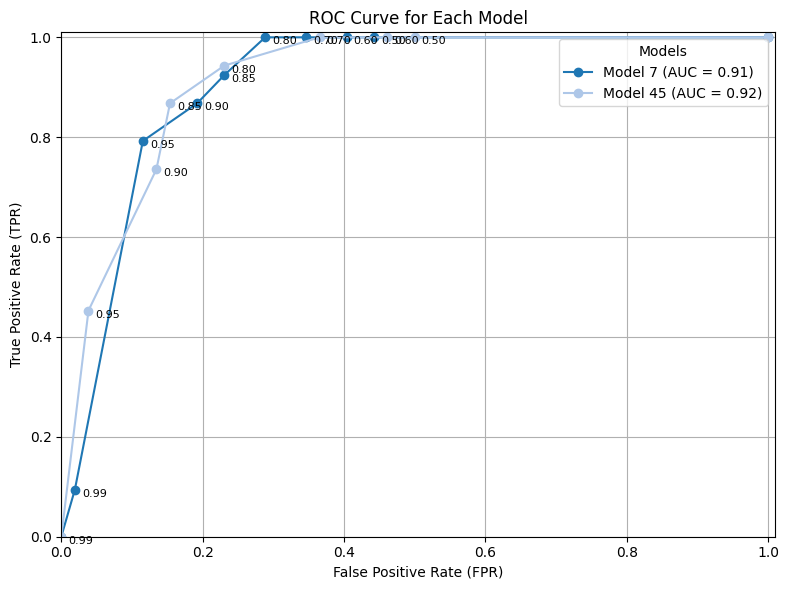

In [ ]:
#@title plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_curves(apmt, figsize=(8, 6), annotate_thresholds=True):
    """Plot ROC curves for each model with optional threshold annotations and AUC calculation."""
    fig, ax = plt.subplots(figsize=figsize)

    models = apmt['model_num'].unique()
    cmap = plt.colormaps.get_cmap('tab20')

    for idx, model in enumerate(models):
        model_data = apmt[apmt['model_num'] == model].sort_values('FPR')

        # Extract FPR and TPR
        fpr = model_data['FPR'].tolist()
        tpr = model_data['TPR'].tolist()

        # Ensure (0, 0) is at the beginning
        if fpr[0] > 0.0:
            fpr.insert(0, 0.0)
            tpr.insert(0, 0.0)

        # Ensure (1, 1) is at the end
        if fpr[-1] < 1.0:
            fpr.append(1.0)
            tpr.append(1.0)

        # Compute AUC
        model_auc = auc(fpr, tpr)

        # Plot ROC curve
        ax.plot(
            fpr,
            tpr,
            marker='o',
            label=f'Model {model} (AUC = {model_auc:.2f})',
            color=cmap(idx)
        )

        # Annotate thresholds
        if annotate_thresholds:
            for _, row in model_data.iterrows():
                ax.annotate(
                    f"{row['threshold']:.2f}",
                    xy=(row['FPR'], row['TPR']),
                    xytext=(5, -5),
                    textcoords='offset points',
                    fontsize=8
                )

    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title('ROC Curve for Each Model')
    ax.legend(title='Models')
    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

df = db.copy()
# df = df[df['model_num'].isin([32, 7, 11, 12, 13, 14, 15])]
df = df[df['model_num'].isin([7, 45])]


# df.loc[df['det_category'].isin(['FP', 'FN', 'TN']), nan_replace_metrics] = 0

apmt = df.groupby(['model_num', 'threshold'])[metrics].mean().reset_index()
apmt['count_TP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TP').sum()).values
apmt['count_TN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TN').sum()).values
apmt['count_FP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FP').sum()).values
apmt['count_FN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FN').sum()).values
apmt['det_prec'] = apmt['count_TP'] / (apmt['count_TP'] + apmt['count_FP'])
apmt['det_rec'] = apmt['count_TP'] / (apmt['count_TP'] + apmt['count_FN'])
apmt['det_f1'] = 2 * (apmt['det_prec'] * apmt['det_rec']) / (apmt['det_prec'] + apmt['det_rec'])
apmt['det_acc'] = (apmt['count_TP'] + apmt['count_TN'])/(apmt['count_TP']+apmt['count_FP']+apmt['count_FN']+apmt['count_TN'])
apmt['TPR'] = apmt['count_TP'] / (apmt['count_TP'] + apmt['count_FN'])
apmt['FPR'] = apmt['count_FP'] / (apmt['count_FP'] + apmt['count_TN'])

plot_roc_curves(apmt)

### specific models

In [ ]:
combinations = [(7, 0.95), (45, 0.85)]

In [ ]:
df = db.copy()
df = df[[ (row['model_num'], row['threshold']) in combinations for _, row in df.iterrows() ]]

apmt = df.groupby(['model_num', 'threshold'])[metrics].mean().reset_index()
apmt['count_TP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TP').sum()).values
apmt['count_TN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TN').sum()).values
apmt['count_FP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FP').sum()).values
apmt['count_FN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FN').sum()).values
apmt['det_acc'] = (apmt['count_TP'] + apmt['count_TN'])/(apmt['count_TP']+apmt['count_FP']+apmt['count_FN']+apmt['count_TN'])
apmt['det_prec'] = apmt['count_TP'] / (apmt['count_TP'] + apmt['count_FP'])
apmt['det_rec'] = apmt['count_TP'] / (apmt['count_TP'] + apmt['count_FN'])
apmt['det_f1'] = 2 * (apmt['det_prec'] * apmt['det_rec']) / (apmt['det_prec'] + apmt['det_rec'])
apmt['TPR'] = apmt['count_TP'] / (apmt['count_TP'] + apmt['count_FN'])
apmt['FPR'] = apmt['count_FP'] / (apmt['count_FP'] + apmt['count_TN'])
apmt

,model_num,threshold,img_precision,img_recall,img_f1,img_accuracy,img_iou,count_TP,count_TN,count_FP,count_FN,det_acc,det_prec,det_rec,det_f1,TPR,FPR
0,7,0.95,0.315502,0.222471,0.227360,0.943929,0.186292,42,46,6,11,0.838095,0.875000,0.792453,0.831683,0.792453,0.115385
1,45,0.85,0.312800,0.284885,0.264169,0.933792,0.215725,46,44,8,7,0.857143,0.851852,0.867925,0.859813,0.867925,0.153846


In [ ]:
df = db.copy()
df = df[[ (row['model_num'], row['threshold']) in combinations for _, row in df.iterrows() ]]

cats = ['TP']
print(f">>> filtering categories: {cats}")
df = df[df['det_category'].isin(cats)]

apmt = df[df['det_category'].isin(cats)].groupby(['model_num', 'threshold'])[metrics].mean().reset_index()
apmt['count_TP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TP').sum()).values
apmt['count_TN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TN').sum()).values
apmt['count_FP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FP').sum()).values
apmt['count_FN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FN').sum()).values
apmt[['model_num', 'threshold', 'img_accuracy', 'img_iou']]

>>> filtering categories: ['TP']


,model_num,threshold,img_accuracy,img_iou
0,7,0.95,0.900272,0.465729
1,45,0.85,0.896421,0.492417


In [ ]:
df = db.copy()
df = df[[ (row['model_num'], row['threshold']) in combinations for _, row in df.iterrows() ]]

cats = ['TP', 'FN']
print(f">>> filtering categories: {cats}")
df = df[df['det_category'].isin(cats)]

apmt = df[df['det_category'].isin(cats)].groupby(['model_num', 'threshold'])[metrics].mean().reset_index()
apmt['count_TP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TP').sum()).values
apmt['count_TN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'TN').sum()).values
apmt['count_FP'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FP').sum()).values
apmt['count_FN'] = df.groupby(['model_num', 'threshold'])['det_category'].apply(lambda x: (x == 'FN').sum()).values
apmt[['model_num', 'threshold', 'img_accuracy', 'img_iou']]

>>> filtering categories: ['TP', 'FN']


,model_num,threshold,img_accuracy,img_iou
0,7,0.95,0.895349,0.369068
1,45,0.85,0.894910,0.427380
